# Reinforced Learning: Snake Game Deep Q-Learning Model
Project 6:Use Reinforced Learning (RL) to build the project. Submit your project as Jupyter notebook.

Alfonso Rocha

Created 04/24/2025

This project focuses on creating a Reinforced Learning model that plays the game snake. 
# Table of Contents

- [Import Required System Files](#Import-Required-System-Files:)
- [1. Create the Snake Enviroment](#1.-Create-the-Snake-Enviroment)
- [2. Creating the Model](#2.-Creating-the-Model)
- [3. Training the Model](#3.-Training-the-Model)
- [4. Plot](#4.-Plot)
- [5. Conclusions](#5.-Conclusions)



## Import Required System Files:
#### Import necessary libraries for data processing and handling

In [1]:
import kagglehub
from pathlib import Path
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd 
import os
from shutil import copyfile
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import matplotlib.pyplot as plt
from itertools import chain
import random
%matplotlib inline 
from matplotlib.image import imread
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler

## 1. Create the Snake Enviroment 

#### In this section we define the Snake environment.
#### We initialize the snake’s starting position, set up the movement directions, spawn food, 
#### handle collisions, and represent the game state as an array that can be used by the agent.

In [2]:
import pygame

class SnakeEnv:
    def __init__(self):
        self.grid_size = 12
        self.DIRECTIONS = [(-1, 0), (0, 1), (1, 0), (0, -1)]  # UP, RIGHT, DOWN, LEFT
        self.direction_idx = random.randint(0, 3)
        self.reset()

    def reset(self):
        self.snake = [(self.grid_size // 2, self.grid_size // 2)]
        self.direction_idx = 1  # Reset facing RIGHT
        self.direction = self.DIRECTIONS[self.direction_idx]
        self.spawn_food()
        self.done = False
        self.food_eaten = 0
        return self.get_state()
        
    def get_state(self):
        head_x, head_y = self.snake[-1]
        point_l = (head_x + self.DIRECTIONS[(self.direction_idx - 1) % 4][0],
                   head_y + self.DIRECTIONS[(self.direction_idx - 1) % 4][1])
        point_r = (head_x + self.DIRECTIONS[(self.direction_idx + 1) % 4][0],
                   head_y + self.DIRECTIONS[(self.direction_idx + 1) % 4][1])
        point_s = (head_x + self.direction[0], head_y + self.direction[1])
    
        danger_straight = (
            point_s in self.snake or
            not (0 <= point_s[0] < self.grid_size) or
            not (0 <= point_s[1] < self.grid_size)
        )
        danger_left = (
            point_l in self.snake or
            not (0 <= point_l[0] < self.grid_size) or
            not (0 <= point_l[1] < self.grid_size)
        )
        danger_right = (
            point_r in self.snake or
            not (0 <= point_r[0] < self.grid_size) or
            not (0 <= point_r[1] < self.grid_size)
        )
    
        food_dx = self.food[0] - head_x
        food_dy = self.food[1] - head_y
    
        return np.array([
            int(danger_straight),
            int(danger_left),
            int(danger_right),
            self.direction_idx == 0,  # UP
            self.direction_idx == 1,  # RIGHT
            self.direction_idx == 2,  # DOWN
            self.direction_idx == 3,  # LEFT
            food_dx < 0,  # food is to the LEFT
            food_dx > 0,  # food is to the RIGHT
            food_dy < 0,  # food is UP
            food_dy > 0   # food is DOWN
        ], dtype=np.float32)
        
    def spawn_food(self):
        while True:
            self.food = (
                random.randint(0, self.grid_size - 1),
                random.randint(0, self.grid_size - 1)
            )
            if self.food not in self.snake:
                break

    def step(self, action):
        # Turn left (0), straight (1), or right (2)
        if action == 0:
            self.direction_idx = (self.direction_idx - 1) % 4
        elif action == 2:
            self.direction_idx = (self.direction_idx + 1) % 4
        # action == 1 -> go straight (no change)
    
        self.direction = self.DIRECTIONS[self.direction_idx]
    
        # Move head
        head_x, head_y = self.snake[-1]
        new_head = (head_x + self.direction[0], head_y + self.direction[1])
    
        # Check collision before moving
        if (
            new_head in self.snake or
            not (0 <= new_head[0] < self.grid_size) or
            not (0 <= new_head[1] < self.grid_size)
        ):
            self.done = True
            return self.get_state(), -10, self.done, {}  
    
        # Move snake forward
        self.snake.append(new_head)
    
        # Check if food eaten
        if new_head == self.food:
            reward = 10  
            self.food_eaten += 1
            self.spawn_food()
        else:
            self.snake.pop(0)  
            reward = -0.1  
    
        return self.get_state(), reward, self.done, {}

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


#### In this section we create a visualizer for the Snake game using Pygame. 
#### It initializes the game window, displays the snake and food on the screen, 
#### updates the graphics each frame, and controls the frame rate.
#### It sets up the color of the snake and the background

In [3]:
class SnakeGameVisualizer:
    def __init__(self, grid_size=20, tile_size=20):
        self.grid_size = grid_size
        self.tile_size = tile_size
        self.screen_size = grid_size * tile_size

        pygame.init()
        self.screen = pygame.display.set_mode((self.screen_size, self.screen_size))
        pygame.display.set_caption("Snake RL")
        self.clock = pygame.time.Clock()

    def draw(self, snake, food):
        self.screen.fill((0, 200, 0))  # Green background

        # Draw food
        food_rect = pygame.Rect(food[1] * self.tile_size, food[0] * self.tile_size, self.tile_size, self.tile_size)
        pygame.draw.rect(self.screen, (255, 0, 0), food_rect)  # Red apple

        # Draw snake
        for i, (x, y) in enumerate(snake):
            color = (100, 100, 255) if i < len(snake) - 1 else (200, 100, 255)  # Head = purple
            pygame.draw.rect(
                self.screen,
                color,
                pygame.Rect(y * self.tile_size, x * self.tile_size, self.tile_size, self.tile_size)
            )

        pygame.display.flip()
        self.clock.tick(10)  # 10 FPS

## 2. Creating the Model

#### In this section, we build a deep neural network to predict the best move for the snake agent.
#### The input is a 11-dimensional state vector describing the environment.
#### The model has four ReLU-activated Dense layers and outputs three values representing action scores.
#### We use the Adam optimizer for efficient gradient updates and Mean Squared Error as the loss function.

In [4]:
import tensorflow as tf

input_shape = [4]     # 4 float features
n_outputs = 3         

model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu", input_shape=[11]),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3)  # 3 actions: left, straight, right
])

C:\Users\alfon\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,403 (181.26 KB)

 Trainable params: 46,403 (181.26 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.MeanSquaredError()

## 3. Training the Model


#### In this section, we train the snake agent using Deep Q-Learning.
#### We use an epsilon-greedy policy for balancing exploration and exploitation, and update the model weights after every step.
#### Rewards are accumulated, epsilon decays gradually, and the best-performing snake and model are saved during training.

In [7]:
def epsilon_greedy_policy(state, epsilon):
    if np.random.rand() < epsilon:
        return np.random.randint(3)  # Choose randomly from 3 actions
    else:
        Q_values = model(np.array([state]), training=False)
        return int(np.argmax(Q_values[0]))  # Choose best Q-value

In [8]:
env = SnakeEnv()  # ← create the environment

In [9]:
best_snake = []
best_food = ()
plot_scores = []
actions_this_episode = []
plot_mean_scores = []
total_score = 0
record = float('-inf')  # Best score seen so far

# Training hyperparameters
episodes = 5000
gamma = 0.95
epsilon = 1.0
min_epsilon = 0.01
epsilon_decay = 0.995

for episode in range(episodes):
    state = env.reset()
    done = False
    total_reward = 0
    actions_this_episode = []
    
    while not done:
        # Choose action (explore or exploit)
        action = epsilon_greedy_policy(state, epsilon)
        actions_this_episode.append(action)
        # Take action
        next_state, reward, done, _ = env.step(action)
        total_reward += reward

        # Estimate future rewards (Bellman update)
        next_Q_values = model(np.array([next_state]), training=False)
        max_next_Q = np.max(next_Q_values[0])
        target_Q = reward + (gamma * max_next_Q * (1 - int(done)))

        # Update Q-network
        with tf.GradientTape() as tape:
            Q_values = model(np.array([state]), training=True)
            Q_value = Q_values[0, action]
            loss = loss_fn([target_Q], [Q_value])

        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        #  Save state BEFORE crash
        if not done:
            state = next_state

    #  Episode done — evaluate performance
    score = env.food_eaten

    if score > record:
        record = score
        best_snake = list(env.snake)
        best_food = env.food
        best_model_weights = model.get_weights()
        best_actions = list(actions_this_episode)

    # Decay epsilon
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Track scores
    total_score += score
    plot_scores.append(score)
    mean_score = total_score / (episode + 1)
    plot_mean_scores.append(mean_score)

    # Progress printout
    if episode % 50 == 0:
        print(f" Episode {episode} | Score: {score} | Total Reward: {total_reward:.2f} |"
              f" Mean Score: {mean_score:.2f} | Record: {record} | Epsilon: {epsilon:.3f}")


 Episode 0 | Score: 1 | Total Reward: -1.70 | Mean Score: 1.00 | Record: 1 | Epsilon: 0.995
 Episode 50 | Score: 0 | Total Reward: -16.80 | Mean Score: 0.24 | Record: 2 | Epsilon: 0.774
 Episode 100 | Score: 1 | Total Reward: -4.50 | Mean Score: 0.32 | Record: 2 | Epsilon: 0.603
 Episode 150 | Score: 0 | Total Reward: -17.20 | Mean Score: 0.27 | Record: 2 | Epsilon: 0.469
 Episode 200 | Score: 0 | Total Reward: -18.60 | Mean Score: 0.27 | Record: 3 | Epsilon: 0.365
 Episode 250 | Score: 1 | Total Reward: -10.60 | Mean Score: 0.30 | Record: 3 | Epsilon: 0.284
 Episode 300 | Score: 0 | Total Reward: -22.80 | Mean Score: 0.34 | Record: 3 | Epsilon: 0.221
 Episode 350 | Score: 0 | Total Reward: -24.20 | Mean Score: 0.39 | Record: 5 | Epsilon: 0.172
 Episode 400 | Score: 0 | Total Reward: -15.80 | Mean Score: 0.44 | Record: 6 | Epsilon: 0.134
 Episode 450 | Score: 0 | Total Reward: -13.80 | Mean Score: 0.56 | Record: 7 | Epsilon: 0.104
 Episode 500 | Score: 2 | Total Reward: 8.70 | Mean Sco

## 4. Plot

#### In this section, we visualize the agent’s performance over time.
#### We plot both the score achieved in each episode and the moving average of scores.
#### This helps us track learning progress, stability, and improvements during training.

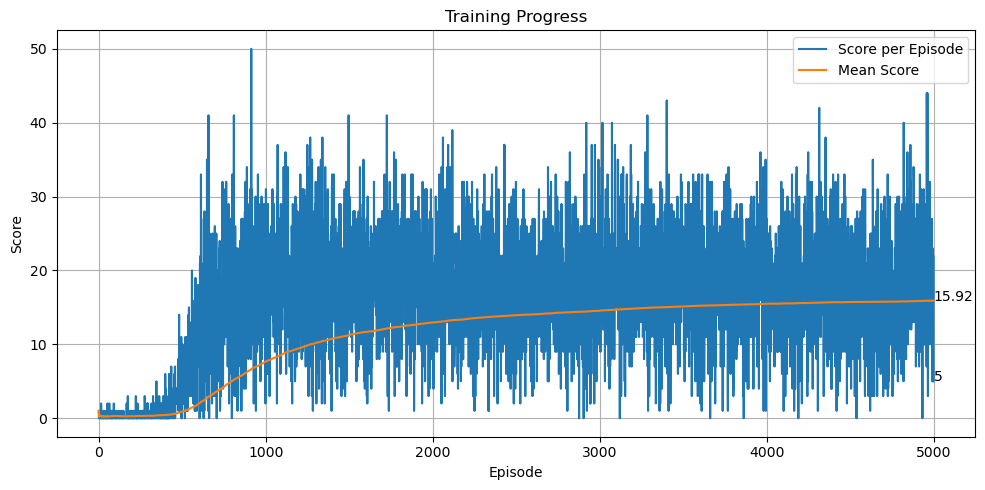

In [11]:

def plot_training(scores, means, record):
    plt.figure(figsize=(10, 5))
    plt.title("Training Progress")
    plt.xlabel("Episode")
    plt.ylabel("Score")
    plt.plot(scores, label="Score per Episode")
    plt.plot(means, label="Mean Score")
    plt.text(len(scores)-1, scores[-1], str(int(scores[-1])))
    plt.text(len(means)-1, means[-1], f"{means[-1]:.2f}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_training(plot_scores, plot_mean_scores, record)

## 5. Conclusions

#### In this project, we successfully created a simple reinforcement learning agent to play Snake.
#### We built a custom environment, trained a deep neural network using Q-learning principles, and visualized the agent's progress.
#### Over time, the agent improved its performance by balancing exploration and exploitation, learning how to survive longer and collect more food.
#### One way we can make the code is better is being able to make a visualization work of the snake game. 